<a href="https://colab.research.google.com/github/CeNCOOS/shoreERDDAP/blob/master/M1_access_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a special version of a [Jupyter notebook](http://jupyter.org). If you don't know what that is or how to run one, that is OK. You can run it in this browser without downloading anything. You will need to log into your google account.

To run in Google Colab:
Go to **Runtime** (in the menu above)
Select the **Run All** command

The code might take a little while the first time, since it has to download a couple of special python packages.

If you have questions or comments, reach out to us at cencoos_staff@mbari.org.

In [1]:
# This stuff is all boilerplate for downloading important packages
# It might take a little while the first time it runs, because its downloading a couple of large packages
!pip install xarray
!pip install netcdf4
!pip install cmocean
!pip install thredds_crawler

from cmocean import cm
import datetime as dt
import pandas as pd
import xarray as xr
import numpy as np
from xml.dom import minidom
import urllib, requests
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from thredds_crawler.crawl import Crawl

## MBARI M1 dataset ##

Tutorial for accessing the data using the xarray package and lazy loading off of the CeNCOOS THREDDS sever.

First, we are going to craw the THREDDS server to get the urls of all of the different M1 deployments and exclude the urls to the subsurface data. This is done using a handy tool called the [thredds_crawer](https://github.com/ioos/thredds_crawler) that hides all of the requests and parsing of the catalog.xml file.



In [2]:
# Find all do the netcdf files in this catalog
c = Crawl("http://thredds.cencoos.org/thredds/catalog/cencoos/staticsensors/m1/catalog.xml", select=[".*nc"])
# Lets filter out files that contain _D_M in the name, which indicates that it is the surface meteorological data
# This piece of funky code 
urls = [s.get("url") for d in c.datasets if d.name.find("_D_M") == -1 for s in d.services if (s.get("service").lower() == "opendap") ] 
[print(u) for u in sorted(urls)]

http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19890821_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19920116_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19920831_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19931104_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19950315_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19960625_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19970731_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19980923_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19991104_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_20001006_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_20011029_D_TMTS.nc

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [3]:
ds = xr.open_dataset(urls[0])
ds

<xarray.Dataset>
Dimensions:    (DEPTH: 11, LATITUDE: 1, LONGITUDE: 1, TIME: 52272)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2017-08-08T19:55:38 ... 2018-08-06T19:45:38
  * DEPTH      (DEPTH) float32 1.0 10.0 20.0 40.0 ... 150.0 200.0 250.0 300.0
  * LATITUDE   (LATITUDE) float32 36.75
  * LONGITUDE  (LONGITUDE) float32 -122.03
Data variables:
    TEMP       (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    TEMP_QC    (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    PSAL       (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    PSAL_QC    (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    CNDC       (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    CNDC_QC    (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    PRES       (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    PRES_QC    (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
Attributes:
    title:                           "Gridded 10 minute MBARI Mooring M1 Sea ...
    date_created:                    2018-09-19T15:42:58

In [4]:
# Flatten the time record into an array, do the same for depth
depth = ds['DEPTH'].values
time = ds['TIME'].values
# Now lets use the tile function to transpform that data into a 2-D array
record_length = len(time)
times = np.tile(time[1:record_length],(11,1)).T
depths = np.tile(depth,(record_length-1,1))
df = ds.isel(LATITUDE=0,LONGITUDE=0)['TEMP'].to_pandas()
print("depths variable shape:", depths.shape)
print("temperature record shape:", df.iloc[1:record_length].shape)

depths variable shape: (52271, 11)
temperature record shape: (52271, 11)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Text(0.5,1,'M1 Temperature\n 2017-08-08 to 2018-08-06')

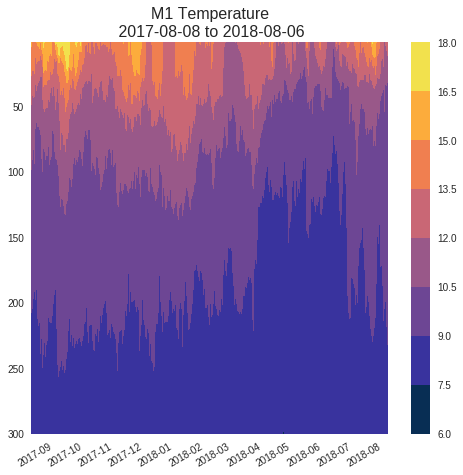

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
cax = ax.contourf(times,depths,df.ix[1:record_length],cmap=cm.thermal)
ax.invert_yaxis()
plt.colorbar(cax)
fig.autofmt_xdate()
ax.set_title("M1 Temperature\n " + str(time[1])[:10] + " to " + str(time[-1])[:10], size=16)